- Feature Columns
>['up_shadow1000','up_shadow1030','up_shadow1100','up_shadow1130','up_shadow1330','up_shadow1400','up_shadow1430','up_shadow1500']
['down_shadow1000','down_shadow1030','down_shadow1100','down_shadow1130','down_shadow1330','down_shadow1400','down_shadow1430','down_shadow1500']
['columnar_len1000','columnar_len1030','columnar_len1100','columnar_len1130','columnar_len1330','columnar_len1400','columnar_len1430','columnar_len1500']
['ret1000', 'ret1030', 'ret1100', 'ret1130', 'ret1330', 'ret1400', 'ret1430', 'ret1500']

- Calculation
> y_df.loc[:,'up_shadow1000'] = (y_df['high1000'].astype(float)-max(y_df['open1000'].astype(float),y_df['close1000'].astype(float)))/y_df['close1000'].astype(float)
y_df.loc[:,'down_shadow1000'] = (y_df['low1000'].astype(float)-min(y_df['open1000'].astype(float),y_df['close1000'].astype(float)))/y_df['close1000'].astype(float)
y_df.loc[:,'columnar_len1000'] = (y_df['open1000'].astype(float)-y_df['close1000'].astype(float))/y_df['close1000'].astype(float)

In [1]:
from __context__ import *
import time
from datetime import datetime
%matplotlib inline
from IPython.core.display import clear_output
# pycoraldb.register_main_globals(globals())
print(pycoraldb.__version__, db.username)
client = db

# from faeval.lft import portfolioTest, PerformanceAnalysis
# from faeval import utility as ut
import tensorflow as tf
import tensorlayer as tl

1.2.6.2 fengwl


## Prepare data

In [2]:
# DB Params Initialized
begindate, enddate = 20170601, 20180101
# begindate, enddate = 20180501, 20180523
rs = db.getTradingDays(begindate, enddate)
datearr = pd.DataFrame(rs.values, columns=rs.columns)
to_filter_code = True

In [3]:
dt_filter =  '_id = irange("{}", "{}")'.format(begindate, enddate)
feature_colns = ['up_shadow1000', 'up_shadow1030', 'up_shadow1100', 'up_shadow1130', 'up_shadow1330', 'up_shadow1400', 'up_shadow1430', 'up_shadow1500', 'down_shadow1000', 'down_shadow1030', 'down_shadow1100', 'down_shadow1130', 'down_shadow1330', 'down_shadow1400', 'down_shadow1430', 'down_shadow1500', 'columnar_len1000', 'columnar_len1030', 'columnar_len1100', 'columnar_len1130', 'columnar_len1330', 'columnar_len1400', 'columnar_len1430', 'columnar_len1500', 'ret1000', 'ret1030', 'ret1100', 'ret1130', 'ret1330', 'ret1400', 'ret1430', 'ret1500']
field_list = ['date', 'code'] + feature_colns
fields = ','.join(field_list)
# fields = ''
all_info = pd.DataFrame(db.getData("pengpy.testtable", dt_filter, fields, password = '123456'))
# all_info = all_info[feature_colns].astype(float)

In [4]:
# upshadow = all_info.filter(like='up_shadow')
# dnshadow = all_info.filter(like='down_shadow')
# columnar = all_info.filter(like='columnar_len')
# prichg = all_info.filter(regex='ret\d+')
# all_info = pd.concat([upshadow, dnshadow, columnar, prichg], 1)
# print(np.hstack([upshadow.columns, dnshadow.columns, columnar.columns, prichg.columns]).tolist())

In [5]:
dt_filter =  '_id = irange("{}", "{}")'.format(begindate, enddate)
fields = 'date,code, adjustment_daily_ret'
return_info = pd.DataFrame(db.getData("gaoxin.new_factor_table", dt_filter, fields, password='123456'))

In [6]:
dt_filter =  '_id = irange("{}", "{}")'.format(begindate, enddate)
fields = ''
basic_info = pd.DataFrame(db.getData("gaoxin.Instruments_Daily_Basic_Info", dt_filter, fields, password='123456'))

In [ ]:
# def __get_data(int_dates):
#     for dt in int_dates:
#         query = {'date': int(dt)}
#         rs = db.getUserData('gaoxin.Instruments_Daily_Basic_Info', query, password = '123456')
#         yield pd.DataFrame(rs)

# old_basic_info = pd.concat(__get_data(datearr['date'].values))
# old_basic_info = old_basic_info[['date', 'code', 'days_to_market']]

In [ ]:
# Merge all data
# rawdata = all_info.merge(return_info, on=['date', 'code'], how='outer')
# rawdata = rawdata.merge(basic_info, on=['date', 'code'], how='outer')
# rawdata = rawdata.merge(old_basic_info, on=['date', 'code'], how='outer')
rawdata = ijoin(all_info, [return_info, basic_info])
rawdata['date_int'] = rawdata['date'].copy()
rawdata['date'] = pd.to_datetime(rawdata['date'], format='%Y%m%d')
rawdata['daily_ret'] = rawdata['daily_ret'].astype(float)
rawdata[feature_colns+['adjustment_daily_ret']] = rawdata[feature_colns+['adjustment_daily_ret']].astype(float)
rawdata_copy = rawdata.copy()

In [ ]:
rawdata = rawdata_copy.copy()
print('shape: ', rawdata.shape)
print(rawdata[['code', 'date']].nunique())
print(rawdata.head())

In [15]:
# rawdata = rawdata_copy.copy()
# ts_codes = db.callTsFunc('getbk', u'800等权')
# codes = [co[2:]+'.'+co[:2] for co in ts_codes]    
# rawdata = rawdata[rawdata['code'].isin(codes)]

In [16]:
"""构建建模数据"""
from gabdnn import compile_3d_data, rebalance_by_class, batch_trimmer, ml_split
rawdf = rawdata.copy()
rawdata = gfc.compress_dataframe(rawdata[feature_colns + ['adjustment_daily_ret']].astype(float))
idx_to_keep = np.array(rawdf['date'] > pd.to_datetime('20180301', format='%Y%m%d'))

adj_ret = rawdf.pivot(index='date', columns='code', values='adjustment_daily_ret')
shifted_ret = adj_ret.shift().stack().rename('shifted_ret')
rawdf = rawdf.set_index(['date', 'code'])[feature_colns].join(shifted_ret)

In [29]:
rawdf_model = rawdf[~idx_to_keep].dropna()
rawdf_keep = rawdf[idx_to_keep].dropna()
X, y = rawdf_model[feature_colns].values, rawdf_model['shifted_ret'].values
print('X: ', X.shape)
print('y: ', y.shape)

X:  (456865, 21, 32)
y:  (456865,)


X_snaps:  (456865, 21, 32)
y_target:  (456865,)
DescribeResult(nobs=456865, minmax=(-0.2891918208, 0.4408602151), mean=0.00038011577674893036, variance=0.00067575362094179, skewness=2.649637685661819, kurtosis=42.31603493868317)


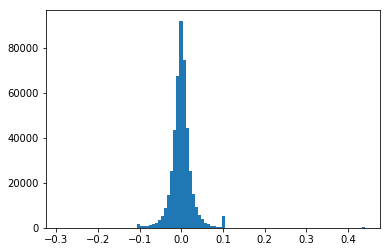

In [18]:
window = 21
X_snaps = gfc.rolling_window(X, window, axis=0)[:-1]
y_target = y[window:]
print('X_snaps: ', X_snaps.shape)
print('y_target: ', y_target.shape)
_ = plt.hist(y_target,bins=100)
print(scs.describe(y_target))
data_xs, data_ys = X_snaps, y_target

In [19]:
# Categorize and rebalance sample size
# data_ys = np.digitize(data_ys, [9800, 10200])
data_ys = np.digitize(data_ys, [-0.09, -0.01, 0.01, 0.09])
print(pd.value_counts(data_ys))
data_ys_copy = data_ys.copy()

2    218843
1    120365
3    109862
4      5577
0      2218
dtype: int64


In [20]:
rebalance_sample = False
if rebalance_sample:
    new_sample = list(rebalance_by_class(data_ys, 'max'))
    data_xs = np.vstack([data_xs[v] for _, v in new_sample])
    data_ys = np.hstack([data_ys[v] for _, v in new_sample])
    assert data_xs.shape[0] == data_ys.shape[0]

In [21]:
# 分组
data_x, data_y = batch_trimmer(data_xs, data_ys, 100)
training_x, validate_x, test_x = ml_split(data_x, [.8, .1, .1])
training_y, validate_y, test_y = ml_split(data_y, [.8, .1, .1])

# Categorize
X_train, y_train = training_x.copy(), training_y.copy()
X_validate, y_validate = validate_x.copy(), validate_y.copy()
X_test, y_test = test_x.copy(), test_y.copy()
print(pd.concat([pd.value_counts(eval(s)).rename(s) for s in ['y_train', 'y_validate', 'y_test']], 1))
print('training set: ', training_x.shape)
print('validate set: ', validate_x.shape)
print('test set: ', test_x.shape)
print('total: ', data_x.shape[0])
assert training_x.shape[0] + validate_x.shape[0] + test_x.shape[0] == data_x.shape[0]

   y_train  y_validate  y_test
0   175159       21749   21933
1   175217       21670   21953
2   175038       22025   21777
3   175006       21897   21935
4   174940       22079   21822
training set:  (875360, 21, 32)
validate set:  (109420, 21, 32)
test set:  (109420, 21, 32)
total:  1094200


In [138]:
def conv_block(net, act=tf.nn.relu, shape=(2, 2, 1, 32), stride=(1, 1, 1, 1), 
               W_init=tf.truncated_normal_initializer(stddev=5e-2), b_init=tf.constant_initializer(value=0.0),
               is_train=True, name='1'):
    # The shape of the filters: (filter_height, filter_width, in_channels, out_channels).
    name0 = 'conv/conv' + str('/' + name if len(name) else '')
    net = tl.layers.Conv2dLayer(net, act=act, shape=shape, strides=stride, W_init=W_init, b_init=b_init, name=name0)
    name1 = 'conv/bn' + str('/' + name if len(name) else '')
    net = tl.layers.BatchNormLayer(net, act=tl.act.htanh, is_train=is_train, name=name1)
    return net


def upsample_block(net, act=tf.nn.relu, out_shape=(5, 2, 32), stride=(1, 1, 1, 1), is_train=True, name='1'):
    """
    Notes from tl.layers.DeConv2dLayer
    - shape = [h, w, the number of output channels of this layer, the number of output channel of the previous layer].
    - output_shape = [batch_size, any, any, the number of output channels of this layer].
    - the number of output channel of a layer is its last dimension.

    This function:
    out_shape = (n_out_height, n_out_width, n_out_channel)
    """
    n_out_height, n_out_width, n_out_channel = out_shape
    batch_size, height, width, n_in_channel = net.inputs.shape
    shape = (height.value, width.value, n_out_channel, n_in_channel.value)
    output_shape = (batch_size.value, n_out_height, n_out_width, n_out_channel)

    name0 = 'upsamp/deconv/' + str('/' + name if len(name) else '')
    net = tl.layers.DeConv2dLayer(net, act=act, shape=shape, output_shape=output_shape, strides=stride, name=name0)
    name1 = 'upsamp/bn/' + str('/' + name if len(name) else '')
    net = tl.layers.BatchNormLayer(net, act=tl.act.htanh, is_train=is_train, name=name1)
    return net


def downsample_block(net, filter_size=(3, 3), strides=(2, 2), padding='SAME', is_train=True, name='1'):
    name0 = 'dnsamp/pool/' + str('/' + name if len(name) else '')
    net = tl.layers.MeanPool2d(net, filter_size=filter_size, strides=strides, padding=padding, name=name0)
    name1 = 'dnsamp/bn/' + str('/' + name if len(name) else '')
    net = tl.layers.BatchNormLayer(net, act=tl.act.htanh, is_train=is_train, name=name1)
    return net


def groupsample_block(net, n_filter=32, filter_size=(3, 3), strides=(2, 2), n_group=2, act=None, padding='SAME', is_train=True, name='1'):
    name0 = 'gpsamp/pool/' + str('/' + name if len(name) else '')
    net = tl.layers.GroupConv2d(net, n_filter=32, filter_size=filter_size, strides=strides,
                                n_group=n_group, act=act, padding=padding, name=name0)
    name1 = 'gpsamp/bn/' + str('/' + name if len(name) else '')
    net = tl.layers.BatchNormLayer(net, act=tl.act.htanh, is_train=is_train, name=name1)
    return net


def dense_block(net, n_units=100, act=None, is_train=True, name='1'):
    name0 = 'dense_dense' + str('_' + name if len(name) else '')
    try:
        net = tl.layers.DenseLayer(net, n_units=n_units, act=act, name=name0)
    except AssertionError as e:
        print('[Warning]', name0, ': ', e)
        net = tl.layers.FlattenLayer(net, name='dense/flatten' + str('_' + name if len(name) else ''))
        net = tl.layers.DenseLayer(net, n_units=n_units, act=act, name=name0)
    name1 = 'dense_bn' + str('_' + name if len(name) else '')
    net = tl.layers.BatchNormLayer(net, act=tl.act.htanh, is_train=is_train, name=name1)
    return net

In [6]:
# models
def model(x, is_train=True, reuse=False):
    with tf.variable_scope("binarynet", reuse=reuse):

        xavier_init = tf.contrib.layers.xavier_initializer()

        net = tl.layers.InputLayer(x, name='input')

        # Block
        # net = upsample_block(net, out_shape=(3, 5, 3), act=None, is_train=is_train, name='1')
        net = conv_block(net, shape=(2, 2, 3, 32), act=None, is_train=is_train, 
                         W_init=xavier_init, b_init=None, name='1')
        net = downsample_block(net, filter_size=(2, 2), strides=(1, 1), padding='VALID', is_train=is_train, name='1')
        net = conv_block(net, shape=(2, 2, 32, 32), act=None, is_train=is_train, name='2')

        # FC Layer
        net = dense_block(net, n_units=100, act=None, is_train=is_train, name='1')
        net = dense_block(net, n_units=5, act=tf.nn.softmax, is_train=is_train, name='2')
        
    return net


def simple_model1(x, is_train=True, reuse=False):
    with tf.variable_scope('simple_model1', reuse=reuse):
        pass


def simple_model2(x, is_train=True, reuse=False):
    with tf.variable_scope('simple_model2', reuse=reuse):
        pass


def ResNet(x, is_train=True, reuse=False):
    with tf.variable_scope('ResNet', reuse=reuse):
        pass


In [138]:
# Helper Functions
def accuracy(X, y, batch_size, n=None, shuffle=True):
    loss, acc = 0, 0
    for n_batch, (Xs, ys) in enumerate(tl.iterate.minibatches(X, y, batch_size=batch_size, shuffle=shuffle)):
        err, ac = sess.run([tf_pred_loss, tf_accuracy], feed_dict={x: Xs, y_: ys})
        loss += err
        acc += ac
    return loss / n_batch, acc / n_batch

In [139]:
sess = None

try:
    sess.close()
    tf.InteractiveSession.close(sess)
except Exception:
    pass

# tf.reset_default_graph()
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
batch_size = 21

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [140]:
with graph.as_default():
    # define inferences

    x = tf.placeholder(tf.float32, shape=[batch_size, 21, 1, 32])
    y_ = tf.placeholder(tf.int64, shape=[batch_size])

    # initializer = tf.contrib.layers.xavier_initializer()
    # w1 = tf.Variable(initializer([3, 5]))
    # b1 = tf.Variable(initializer([3, 5]))

    net_train = model(x, is_train=True, reuse=False)
    net_test = model(x, is_train=False, reuse=True)

    # cost for training
    train_y = net_train.outputs
    tf_train_loss = tl.cost.cross_entropy(train_y, y_, name='xentropy')

    # cost and accuracy for evalution
    test_y = net_test.outputs
    tf_pred_loss = tl.cost.cross_entropy(test_y, y_, name='xentropy2')
    tf_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(test_y, 1), y_), tf.float32))

    # define the optimizer
    train_params = tl.layers.get_variables_with_name('binarynet', True, True)
    optimizer = tl.optimizers.AMSGrad(learning_rate=0.005)
    # grads_and_vars = optimizer.compute_gradients(tf_train_loss)
    tf_loss_minimize = optimizer.minimize(tf_train_loss, var_list=train_params)
    # tf_loss_minimize = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost, var_list=train_params)

[TL] InputLayer  binarynet/input: (21, 21, 1, 32)


AttributeError: 'NoneType' object has no attribute '__name__'

In [ ]:
sess.run(tf.global_variables_initializer())
n_epoch = 50
performances_per_epoch = []
for epoch in range(1, n_epoch + 1):
    print('\nStrating epoch {}'.format(epoch))
    start_time = datetime.now()
    batches_i = 0
    loss_per_epoch = []
    for xs, ys in tl.iterate.minibatches(X_train, y_train, batch_size=batch_size, shuffle=True):
        # training for batches
        if batches_i == 0:
            _, loss, acc = sess.run(
                [tf_loss_minimize, tf_train_loss, tf_accuracy],
                feed_dict={x: xs, y_: ys}
            )
            # summ_writer.add_summary(gn_summ, epoch)
            # summ_writer.add_summary(wb_summ, epoch)
        else:
            _, loss, acc = sess.run(
                [tf_loss_minimize, tf_train_loss, tf_accuracy],
                feed_dict={x: xs, y_: ys}
            )
        loss_per_epoch.append(loss)
        batches_i += 1

    try:
        print('Average loss in epoch %d: %.5f' % (epoch, np.mean(loss_per_epoch)))
        avg_loss = np.mean(loss_per_epoch)
    except Exception as e:
        print('Epoch {}: '.format(epoch), e)
        pass

    print("Epoch %d of %d took %.4fs" % (epoch, n_epoch, (datetime.now() - start_time).total_seconds()))

    print('Training Set')
    train_loss, train_acc = accuracy(X_train, y_train, batch_size, shuffle=True)
    print("   train loss: ", train_loss)
    print("   train acc : ", train_acc)

    print('Validation Set')
    validate_loss, validate_acc = accuracy(X_validate, y_validate, batch_size, shuffle=True)
    print("   validation loss: ", validate_loss)
    print("   validation acc : ", validate_acc)

    print('Test Set')
    test_loss, test_acc = accuracy(X_test, y_test, batch_size, shuffle=True)
    print("   test loss: ", test_loss)
    print("   test acc : ", test_acc)

    # Execute the summaries defined above
    # performances_per_epoch.append([train_loss, train_acc, validate_loss, validate_acc, test_loss, test_acc])
    # summ = sess.run(performance_summaries, feed_dict={tf_loss_ph: train_loss, tf_accuracy_ph: validate_loss})

    # Write the obtained summaries to the file, so it can be displayed in the TensorBoard
    # summ_writer.add_summary(summ, epoch)

# save_path = tf.train.Saver().save(sess=sess, save_path=model_dir + '/model.ckpt')
# print("Model saved in path: %s" % save_path)